In [1]:
using Revise, HarmonicBalance;
include("utils.jl")

@variables α, ω, ω0, F, t, η, x(t), γ, Ω, F, ϕ, F1; # declare constant variables and a function x(t)
diff_eq = DifferentialEquation(d(x,t,2) + ω0^2*x + α*x^3 + η*d(x,t)*x^2 + γ*d(x,t) ~ F*cos(ω*t+ϕ), x)
add_harmonic!(diff_eq, x, ω);
harmonic_eq = get_harmonic_equations(diff_eq);
fixed = (α => 1.0, ω0 => 1.0, F => 0.01, η => 0.1, γ=>0.001, ϕ=>0);   # fixed parameters

┌ Info: Precompiling HarmonicBalance [e13b9ff6-59c3-11ec-14b1-f3d2cc6c135e]
└ @ Base loading.jl:1423
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Package HarmonicBalance does not have Plots in its dependencies:
│ - If you have HarmonicBalance checked out for development and have
│   added Plots as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HarmonicBalance
└ Loading Plots into HarmonicBalance from project dependency, future warnings for HarmonicBalance are suppressed.
┌ Warning: You are using Matplotlib 3.1.2, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to instal

# the reference solution diagram

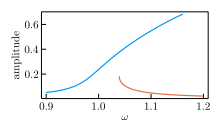

In [23]:
swept = ω => LinRange(0.9, 1.2, 400)              # range of parameter values
res = get_steady_states(harmonic_eq, swept, fixed, random_warmup=true);

Plots.default(linewidth=1.2)
HarmonicBalance.plot1D(res, x="ω", y="sqrt(u1^2 + v1^2)", plot_only=["stable"], yticks=0.0:0.2:0.8,size=(220, 120), bottom_margin=-2mm,xlabel="\$ ω \$", ylabel="amplitude")

In [4]:
savefig(dir * "linresp/duffing_ref.svg")

# progression, high branch

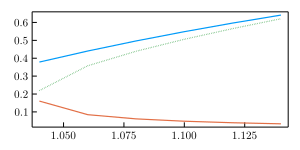

In [25]:
swept_hi = ω => LinRange(0.9, 1.1, 9) # high branch data
swept_lo = ω => LinRange(1.04, 1.14, 6) # low branch data
res_hi = get_steady_states(harmonic_eq, swept_hi, fixed, random_warmup=true)
res_lo = get_steady_states(harmonic_eq, swept_lo, fixed, random_warmup=true)
HarmonicBalance.plot1D(res_lo, x="ω", y="sqrt(u1^2 + v1^2)", size=(300,150))

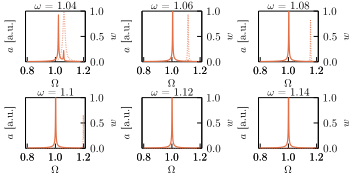

In [21]:
res_grid = res_lo
branch_index = 2
default(c=2)

Ωs = LinRange(0.8,1.2,400)
plots = []

for i in 1:length(res_grid.solutions)
    chosen = res_grid[i][branch_index]
    f = δU_corr(res, chosen)
    data = f.(Ωs)
    a_lin, w_lin = unzip(data);
    this_ω = round(real(HarmonicBalance.substitute(ω, chosen)), digits=3)
    
    p1 = Plots.plot(Ωs, a_lin, xlabel="\$ Ω \$", xticks=range(0.8, step=0.2,stop=1.2), 
        ylabel="\$ a \$ [a.u.]",
        ylim=(0,500),
        yticks=nothing,
        title="\$ ω \$ = " * string(this_ω), 
        top_margin=-1.6mm, 
        left_margin=2mm,
#       right_margin= (2.5+ ((i∈[3,6,9]) ? 2 : 0))mm,
        right_margin=6mm,
    bottom_margin=(-1 + ((i>=7) ? -1.5 : 0))mm)
    
    Plots.plot!(twinx(),Ωs, w_lin, xticks=range(0.8, step=0.2,stop=1.2),
        linestyle=:dot, ylabel="\$ w \$", yticks=LinRange(0.0,1.0,3), yrange=(0,1))
    
    append!(plots, [p1])
end


total = Plots.plot(plots..., size=(350, 260* length(plots) / 9))

In [22]:
savefig(total, dir * "linresp/duff_comp_lo.svg")

# comparison to other methods

In [8]:
# pick a solution and compare the a,w results to RK simulations
res = get_steady_states(harmonic_eq, ω => [1.1,1.2], fixed, random_warmup=true)
chosen = res[1][2]
Ω_lin = LinRange(0.9,1.2,400)
chosen_ω = real(HarmonicBalance.substitute(ω, chosen))
println("ω : ", chosen_ω )

f = δU(res, chosen)
data = f.(Ω_lin);
a_lin, w_lin = unzip(data);

f_corr = δU_corr(res, chosen)
data_corr = f_corr.(Ω_lin);
a_corr, w_corr = unzip(data_corr);

ω : 1.1


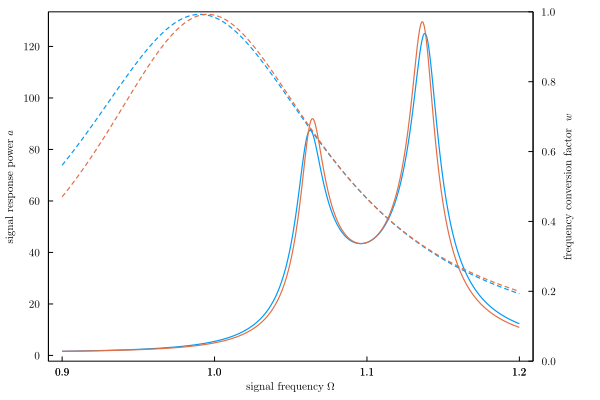

In [9]:
# combined plot to compare methods 
Plots.plot(Ω_lin, a_lin, size=(600,400), xlabel="signal frequency \$ Ω \$", ylabel="signal response power \$a\$",right_margin=15Plots.mm, c=1)
Plots.plot!(Ω_lin, a_corr, c=2)
p = Plots.twinx()
Plots.plot!(p, Ω_lin, w_lin, ylabel="frequency conversion factor  \$ w \$", c=1, linestyle=:dash, ylim=(0,1))
Plots.plot!(p, Ω_lin, w_corr, c=2, linestyle=:dash)

# HarmonicBalance approach

Instead of perturbation theory, let us include all three harmonics in the ansatz and solve the huge polynomial system.

In [10]:
# define ODE 
diff_eq = DifferentialEquation(d(x,t,2) + ω0^2*x + α*x^3 + η*d(x,t)*x^2+ γ*d(x,t) ~ F*cos(ω*t) + F1*cos(Ω*t), x)

# specify the ansatz x = u(T) cos(ωt) + v(T) sin(ωt)
add_harmonic!(diff_eq, x, ω) 
add_harmonic!(diff_eq, x, Ω) 
add_harmonic!(diff_eq, x, 2ω-Ω) 

# implement ansatz to get harmonic equations
harmonic_eq_big = get_harmonic_equations(diff_eq)
problem_hb = Problem(harmonic_eq_big, Jacobian="implicit");

In [11]:
fixed_hb = (α => 1.0, ω0 => 1.0, F => 0.01, η => 0.1, γ => 0.001, ω => 1.1, F1 => 1E-6)   # fixed parameters
swept_hb = Ω => Ω_lin              # range of parameter values
solutions_hb = get_steady_states(problem_hb, swept_hb, fixed_hb, random_warmup=true)

Tracking 729 paths... 100%|█████████████████████████████| Time: 0:00:08
  # paths tracked:                  729
  # non-singular solutions (real):  3 (0)
  # singular endpoints (real):      1 (0)
  # total solutions (real):         4 (0)


A steady state result for 400 parameter points

Solution branches:   3
   of which real:    3
   of which stable:  2

Classes: stable, physical, Hopf, binary_labels


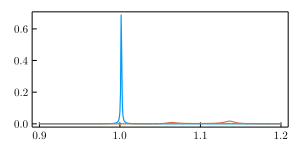

In [27]:
# check which branch is which before proceeding
HarmonicBalance.plot1D(solutions_hb, x="Ω", y="(u2^2 + v2^2 + u3^2 + v3^2) / F1", size=(300,150))

In [13]:
a_form = "(u2^2 + v2^2 + u3^2 + v3^2) / F1^2"
w_form = "0.5 * (1 - (u2^2 + v2^2 - u3^2 - v3^2) / (u2^2 + v2^2 + u3^2 + v3^2))"

# the branch to do comparisons on
branch_hb = 2

a_hb = real.(getindex.(transform_solutions(solutions_hb, a_form), branch_hb))
w_hb = real.(getindex.(transform_solutions(solutions_hb, w_form), branch_hb))
Ω_hb = real.(getindex.(transform_solutions(solutions_hb, "Ω"), branch_hb));

# Time-dependent stuff

In [14]:
response = solution_lab(ω=1.1, ξ=1E-4, Ω=1.13, g=0.01, γ=0.001, cycles=100000, pts_per_cycle=50);

In [15]:
# perform a RK simulation for signal frequency o, return the calculated a and w
function rk(o)

    resp = solution_lab(ω=1.1, ξ=1E-4, Ω=o, g=0.01, γ=0.001, cycles=100000, pts_per_cycle=50);
    #resp_unp = solution_lab(ω=1.1, ξ=0, Ω=o, g=0.01, γ=0.001, cycles=100000, pts_per_cycle=50);
    
    Δω = 0.002
    s0 = Fourier_filter(resp, ω_range=[o- Δω, o+ Δω], pts_per_cycle=50, ringdown_cycles=50000)^2
    s1 = Fourier_filter(resp, ω_range=[2.2-o- Δω, 2.2-o+ Δω], pts_per_cycle=50, ringdown_cycles=50000)^2
    (s0 + s1) / 1E-8, s1 / (s0 + s1)
end

#@time rk_w(1.13)

rk (generic function with 1 method)

In [16]:
Ω_rk = cat(LinRange(0.9,1.1,20), LinRange(1.1,1.2,25), dims=1)
Ω_rk = filter(x ->  abs(x - 1.1) > 0.005, Ω_rk);
a_rk, w_rk = unzip(rk.(Ω_rk));

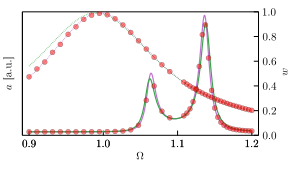

In [17]:
# combined plot to compare methods 

Plots.plot(Ω_hb, a_hb, size=(290 ,170), xlabel="\$ Ω \$", 
    ylabel="\$a\$ [a.u.]", c=4,right_margin=6mm,
    yticks=nothing)
Plots.plot!(Ω_lin, (a_lin).^2, c=3)
Plots.scatter!(Ω_rk, a_rk, c=:red, opacity=0.5, markersize=3)

p = Plots.twinx()
Plots.plot!(p, Ω_hb, w_hb, ylabel=" \$ w \$", c=4, linestyle=:dot, ylim=(0,1))
Plots.plot!(p, Ω_lin, w_lin, c=3, linestyle=:dot)
scatter!(p, Ω_rk, w_rk, c=:red, markersize=3, opacity=0.5)

In [18]:
Plots.savefig(dir * "linresp/duff_benchmark.svg")

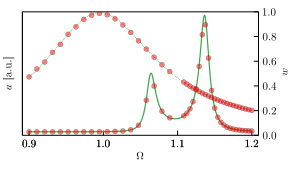

In [19]:
# plotted vs second order
# combined plot to compare methods 

Plots.plot(Ω_lin, a_corr.^2, size=(290,170), xlabel="\$ Ω \$", 
    ylabel="\$a\$ [a.u.]", c=3,right_margin=6mm,
    yticks=nothing)
Plots.scatter!(Ω_rk, a_rk, c=:red, opacity=0.5, markersize=3)

p = Plots.twinx()
Plots.plot!(p, Ω_lin, w_corr, c=3, ylabel=" \$ w \$", linestyle=:dot, ylim=(0,1))
scatter!(p, Ω_rk, w_rk, c=:red, markersize=3, opacity=0.5)

In [20]:
Plots.savefig(dir * "linresp/duff_corrected.svg")